In [21]:
import random
from collections import deque
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter

Compute the single-source dependency scores $δ_s(v)$ for all vertices v in G using the unweighted version of Brandes' algorithm.

In [22]:
def brandes_single_source_dependencies_unweighted(G, s):
    S = []
    P = {v: [] for v in G}
    sigma = dict.fromkeys(G, 0.0)
    dist  = dict.fromkeys(G, -1)

    sigma[s] = 1.0
    dist[s] = 0

    from collections import deque
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])

    return delta

In [23]:
def approx_bc_algorithm1_hybrid(G, c=5.0, cutoff_factor=20, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx] adaptive + cutoff: max {max_bfs} BFS runs (n/{cutoff_factor}), c={c}")

    S = {v: 0.0 for v in nodes}      
    k = {v: 0   for v in nodes}    
    done = {v: False for v in nodes} 
    remaining = n                 

    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
            print(f"[approx] BFS {bfs_used}/{max_bfs}, remaining not-done vertices: {remaining}")

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s, BFS_used={bfs_used}")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }
    return bc_hat, k, bfs_used

In [24]:
def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode='edge')
    return np.convolve(ypad, kernel, mode='valid')

Random Graph Experiment (Figure 1(a))

Random graph: 2000 7980
[approx] adaptive + cutoff: max 100 BFS runs (n/20), c=5.0
[approx] BFS 10/100, remaining not-done vertices: 2000
[approx] BFS 20/100, remaining not-done vertices: 2000
[approx] BFS 30/100, remaining not-done vertices: 2000
[approx] BFS 40/100, remaining not-done vertices: 2000
[approx] BFS 50/100, remaining not-done vertices: 2000
[approx] BFS 60/100, remaining not-done vertices: 2000
[approx] BFS 70/100, remaining not-done vertices: 2000
[approx] BFS 80/100, remaining not-done vertices: 2000
[approx] BFS 90/100, remaining not-done vertices: 2000
[approx] BFS 100/100, remaining not-done vertices: 2000
[approx] finished in 0.38s, BFS_used=100
[hybrid] BFS used = 100, average samples per node = 99.95


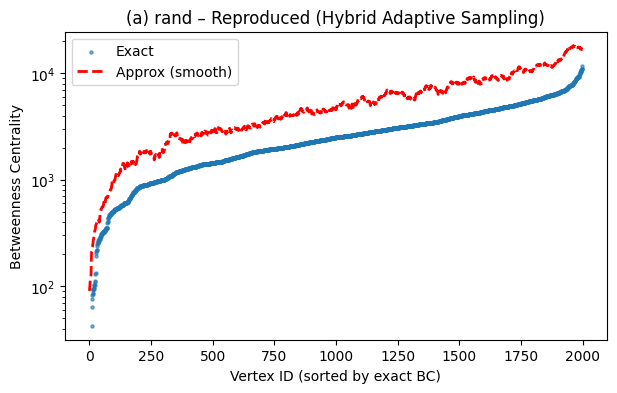

In [25]:
G_rand = nx.gnm_random_graph(n=2000, m=7980, seed=42)

print("Random graph:", G_rand.number_of_nodes(), G_rand.number_of_edges())

# Compute approximate using HYBRID adaptive sampling
approx_rand, k_used, bfs_used = approx_bc_algorithm1_hybrid(
    G_rand, c=5.0, cutoff_factor=20, seed=0
)

print(f"[hybrid] BFS used = {bfs_used}, average samples per node = {np.mean(list(k_used.values())):.2f}")

#Exact Brandes
exact_rand = nx.betweenness_centrality(G_rand, normalized=False)

# Plot
nodes_sorted = sorted(exact_rand.keys(), key=lambda v: exact_rand[v])
x = np.arange(len(nodes_sorted))

y_exact  = np.array([exact_rand[v]  for v in nodes_sorted])
y_approx = np.array([approx_rand[v] for v in nodes_sorted])
y_smooth = smooth_series(y_approx)

plt.figure(figsize=(7,4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(a) rand – Reproduced (Hybrid Adaptive Sampling)")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()

citation network

In [27]:
def load_cite(path="../data/real-world-old/cite_network_edgelist.txt"):
    G = nx.DiGraph()
    with open(path) as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 2:
                u = int(parts[0])
                v = int(parts[1])
                G.add_edge(u, v)
    print("Cite graph:", G.number_of_nodes(), G.number_of_edges())
    return G

G_cite = load_cite()

Cite graph: 8324 41601


[approx] adaptive + cutoff: max 416 BFS runs (n/20), c=5.0
[approx] BFS 10/416, remaining not-done vertices: 8324
[approx] BFS 20/416, remaining not-done vertices: 8324
[approx] BFS 30/416, remaining not-done vertices: 8324
[approx] BFS 40/416, remaining not-done vertices: 8324
[approx] BFS 50/416, remaining not-done vertices: 8324
[approx] BFS 60/416, remaining not-done vertices: 8324
[approx] BFS 70/416, remaining not-done vertices: 8324
[approx] BFS 80/416, remaining not-done vertices: 8324
[approx] BFS 90/416, remaining not-done vertices: 8324
[approx] BFS 100/416, remaining not-done vertices: 8324
[approx] BFS 110/416, remaining not-done vertices: 8324
[approx] BFS 120/416, remaining not-done vertices: 8324
[approx] BFS 130/416, remaining not-done vertices: 8324
[approx] BFS 140/416, remaining not-done vertices: 8324
[approx] BFS 150/416, remaining not-done vertices: 8324
[approx] BFS 160/416, remaining not-done vertices: 8324
[approx] BFS 170/416, remaining not-done vertices: 832

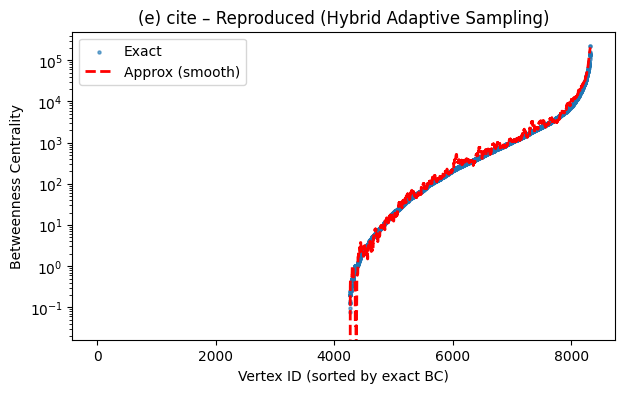

In [28]:
# Approx (Hybrid: adaptive sampling + cutoff n/20)
approx_cite, k_used_cite, bfs_used_cite = approx_bc_algorithm1_hybrid(
    G_cite, c=5.0, cutoff_factor=20, seed=0
)
print(f"[hybrid cite] BFS used = {bfs_used_cite}, "
      f"avg samples per node = {np.mean(list(k_used_cite.values())):.2f}")

# Exact
exact_cite = nx.betweenness_centrality(G_cite, normalized=False)

# Plot
nodes_sorted = sorted(exact_cite.keys(), key=lambda v: exact_cite[v])
x = np.arange(len(nodes_sorted))

y_exact = np.array([exact_cite[v] for v in nodes_sorted])
y_approx = np.array([approx_cite[v] for v in nodes_sorted])
y_smooth = smooth_series(y_approx)

plt.figure(figsize=(7,4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(e) cite – Reproduced (Hybrid Adaptive Sampling)")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()